# Google Mobility Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import os

In [2]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

## Data download

In [3]:
raw_data_dir = 'data/raw'
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [4]:

file_name = 'Google_Global_Mobility_Report.csv'
url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"

file_path = os.path.join(raw_data_dir, file_name)

myfile = requests.get(url)
open(file_path, 'wb').write(myfile.content)

35622250

## Dataset features

In [13]:
goog_mob = pd.read_csv(file_path, parse_dates=['date'])

In [14]:
goog_mob.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [25]:
geoid_columns = goog_mob.columns[:6]
data_columns = goog_mob.columns[7:]
print(geoid_columns)
print(data_columns)

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'iso_3166_2_code', 'census_fips_code'],
      dtype='object')
Index(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')


In [19]:
print(f"Unique countries in dataset: {len(goog_mob.country_region.unique())}")
# Note if two countries have same region name this number will be wrong:
print(f"Unique sub_regions in dataset: {len(goog_mob.sub_region_1.unique())}") 
print(f"Data in range: {goog_mob.date.min()} to {goog_mob.date.max()}")

Unique countries in dataset: 135
Unique sub_regions in dataset: 1845
Data in range: 2020-02-15 00:00:00 to 2020-06-07 00:00:00


In [29]:
def sum_geo_cols_contents(row, geo_cols):
    out = ""
    for col in geo_cols:
        out += str(row[col]) + '_'
    return out.strip('nan_')
# This is slow avoid to rerun
if "unique_geo_id" not in goog_mob.columns:
    goog_mob["unique_geo_id"] = goog_mob.apply(
        lambda x: sum_geo_cols_contents(x, geoid_columns), axis=1
    )

In [30]:
print(f"Unique unique_geo_id in dataset: {len(goog_mob.unique_geo_id.unique())}") 

Unique unique_geo_id in dataset: 4822


In [41]:
goog_mob["unique_geo_id"] = goog_mob["unique_geo_id"].str.strip('nan_')

## Reindex data

Use a multi index to separate date and geography information

In [43]:
goog_mob.set_index(
    pd.MultiIndex.from_frame(goog_mob[['unique_geo_id', 'date']]
), inplace=True)

Add a helper function to explore the available geo_ids

In [61]:
def find_matching_geo_id(
    goog_mob, 
    find_str='FR_France', 
    exclude_str='This garbage is not a country name'
):
    return [
        name for name in goog_mob.unique_geo_id.unique()
            if find_str in name 
            if exclude_str not in name
    ]

## Plotting data for google 

In [63]:
print(find_matching_geo_id(goog_mob, 'GB_United Kingdom', 'nan_'))

['GB_United Kingdom', 'GB_United Kingdom_Greater Londo', 'GB_United Kingdom_Greater Manchester', 'GB_United Kingdom_Merseyside', 'GB_United Kingdom_Na h-Eileanan an Iar', 'GB_United Kingdom_South Yorkshire', 'GB_United Kingdom_Tyne and Wear', 'GB_United Kingdom_West Midlands', 'GB_United Kingdom_West Yorkshire']


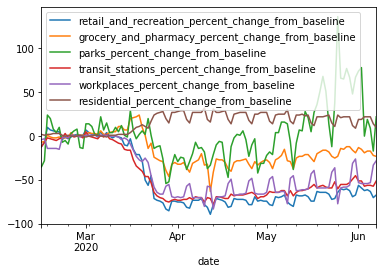

In [65]:
goog_mob.loc['GB_United Kingdom'].plot(y=data_columns)

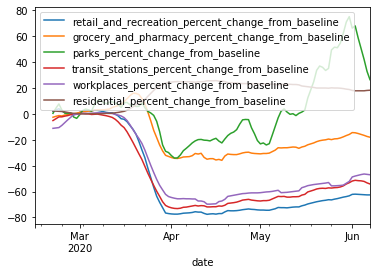

In [72]:
goog_mob.loc['GB_United Kingdom', data_columns].rolling(7).mean().plot()

## Notes on the google mobility data

This data corresponds to the number of visits for given types of locations as measured
by Google.

The baseline frequentation was measured between the 03/01/2020 and the 06/02/2020 and is normalised per day of the week.
This causes some artifacts, notably an apparent increase in workplace frequentation on week-ends. This is NOT an absolute
increase of frequentation on week-ends. This only suggests that essential workers represent a higher proportion of week-end
workers in normal times.

This justifies the use of a 7 day moving average IF we are merging with datasets which do not have a daily granularity.

